### Обучение на NewsAggrregatorKaggleFN
Тестирование на Fake and real news dataset

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random

SEED = 42

In [ ]:
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [ ]:
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import nltk
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import transformers
import sentencepiece

from transformers import AlbertTokenizer
from sklearn.metrics import roc_curve, confusion_matrix,auc, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
news_data = pd.read_csv('/content/drive/MyDrive/Data/NewsAgreggatorKaggleFNforBERT.csv')
news_data.head()

,title,label
0,supply demand chain executive oil falls to aro...,0
1,london south east major averages climb off low...,0
2,gabrielle cintorino new poll shows support for...,1
3,artist s impression of the clinton machine rus...,1
4,worcester telegram s p gains on global growth ...,0


In [ ]:
print(news_data['title'])

0        supply demand chain executive oil falls to aro...
1        london south east major averages climb off low...
2        gabrielle cintorino new poll shows support for...
3        artist s impression of the clinton machine rus...
4        worcester telegram s p gains on global growth ...
                               ...                        
24633    qfinance com global markets world stocks coppe...
24634    david gutierrez staff writer why hydrogen pero...
24635    bay news spacex preps falcon rocket for pre da...
24636    law subscription jos a bank men s wearhouse in...
24637    hillary clinton laundered isis cash says inves...
Name: title, Length: 24638, dtype: object


In [ ]:
news_data.isnull().sum()

title    180
label      0
dtype: int64

In [ ]:
news_data = news_data.dropna()

In [ ]:
news_data.isnull().sum()

title    0
label    0
dtype: int64

In [ ]:
#separating the data and label
X = news_data['title'].values
Y = news_data['label'].values

In [ ]:
print(X)

['supply demand chain executive oil falls to around after china japan data'
 'london south east major averages climb off lows but remain in the red'
 'gabrielle cintorino new poll shows support for police officers is on the rise cop haters will be furious'
 ... 'bay news spacex preps falcon rocket for pre dawn launch sunday'
 'law subscription jos a bank men s wearhouse ink b merger deal'
 'hillary clinton laundered isis cash says investigating u s army officer']


In [ ]:
print(Y)

[0 0 1 ... 0 0 1]


In [ ]:
EPOCHS=2
max_seq_length = 60
LEARNING_RATE=1e-5
early_stopping=early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
# # First load the real tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

### Fine-tuning Model

In [ ]:
from transformers import TFAlbertModel

In [ ]:
bert_layers = TFAlbertModel.from_pretrained('albert-base-v2')

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

train_input_ids, train_attention_masks = bert_encode(X_train, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def build_model(transformer_layer,max_len=max_seq_length):
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

    output = bert_layers([input_ids,attention_masks])
    output = output[1]
    net = tf.keras.layers.Dense(32,activation='relu')(output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
    outputs = net
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)
    
    
    return model

In [ ]:
def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ALBERT')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc')]

In [ ]:
model = build_model(bert_layers, max_len=max_seq_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=METRICS)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  TFBaseModelOutputWi  11683584   ['input_ids[0][0]',              
 )                              thPooling(last_hidd               'attention_masks[0][0]']        
                                en_state=(None, 60,                                               
                                 768),                                                        

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    Y_train,
    validation_split=0.2, 
    epochs=2,
    batch_size=32)

Epoch 1/2
490/490 [==============================] - 239s 441ms/step - loss: 0.2025 - tp: 7083.0000 - fp: 623.0000 - tn: 7254.0000 - fn: 692.0000 - accuracy: 0.9160 - precision: 0.9192 - recall: 0.9110 - auc: 0.9751 - val_loss: 0.0887 - val_tp: 1869.0000 - val_fp: 57.0000 - val_tn: 1921.0000 - val_fn: 67.0000 - val_accuracy: 0.9683 - val_precision: 0.9704 - val_recall: 0.9654 - val_auc: 0.9954
Epoch 2/2
490/490 [==============================] - 203s 415ms/step - loss: 0.0641 - tp: 7583.0000 - fp: 153.0000 - tn: 7724.0000 - fn: 192.0000 - accuracy: 0.9780 - precision: 0.9802 - recall: 0.9753 - auc: 0.9966 - val_loss: 0.0746 - val_tp: 1891.0000 - val_fp: 69.0000 - val_tn: 1909.0000 - val_fn: 45.0000 - val_accuracy: 0.9709 - val_precision: 0.9648 - val_recall: 0.9768 - val_auc: 0.9964


In [ ]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 22s 143ms/step - loss: 0.0682 - tp: 2396.0000 - fp: 85.0000 - tn: 2379.0000 - fn: 32.0000 - accuracy: 0.9761 - precision: 0.9657 - recall: 0.9868 - auc: 0.9966


In [ ]:
print(f'ALBERT accuracy: {score[5]}')

ALBERT accuracy: 0.9760833978652954


In [ ]:
y_predict_prob=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 24s 139ms/step


In [ ]:
print(classification_report(Y_test,  np.round(y_predict_prob)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2464
           1       0.97      0.99      0.98      2428

    accuracy                           0.98      4892
   macro avg       0.98      0.98      0.98      4892
weighted avg       0.98      0.98      0.98      4892



In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print('ALBERT: ROC AUC=%.4f' % roc_auc_score(Y_test, y_predict_prob))

ALBERT: ROC AUC=0.9971


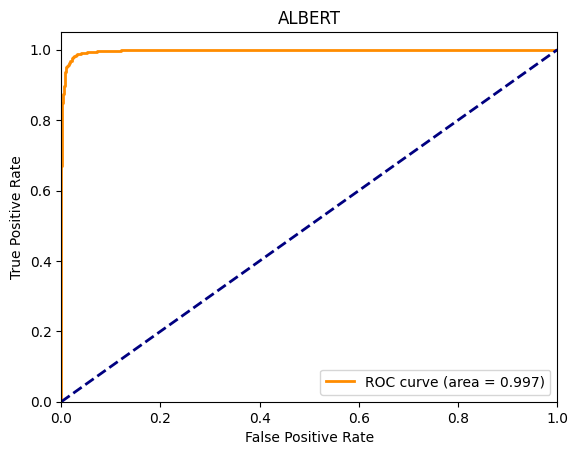

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_predict_prob)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

**Testing: Fake and real news dataset**

In [ ]:
news_test = pd.read_csv('/content/drive/MyDrive/Data/FNDatasetBERT.csv')

In [ ]:
x_test = news_test['title'].values
y_test = news_test['label'].values

In [ ]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 203s 145ms/step - loss: 0.8737 - tp: 22788.0000 - fp: 8668.0000 - tn: 12749.0000 - fn: 693.0000 - accuracy: 0.7915 - precision: 0.7244 - recall: 0.9705 - auc: 0.8842


In [ ]:
print(f'ALBERT accuracy FNDataset: {score[5]}')

ALBERT accuracy FNDataset: 0.7915052175521851


In [ ]:
model.save('/content/drive/MyDrive/Models/FINAL/ALBERT.h5')

### Training Classifier

In [ ]:
bert_layers = TFAlbertModel.from_pretrained('albert-base-v2')

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [ ]:
model = build_model(bert_layers, max_len=max_seq_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=METRICS)

In [ ]:
model.layers[2].trainable = False

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_albert_model_1 (TFAlbertMod  TFBaseModelOutputWi  11683584   ['input_ids[0][0]',              
 el)                            thPooling(last_hidd               'attention_masks[0][0]']        
                                en_state=(None, 60,                                               
                                 768),                                                      

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    Y_train,
    validation_split=0.2, 
    epochs=2,
    batch_size=32)

Epoch 1/2
490/490 [==============================] - 235s 438ms/step - loss: 0.2179 - tp: 29786.0000 - fp: 9343.0000 - tn: 19951.0000 - fn: 1470.0000 - accuracy: 0.8214 - precision: 0.7612 - recall: 0.9530 - auc: 0.8862 - val_loss: 0.1032 - val_tp: 1875.0000 - val_fp: 91.0000 - val_tn: 1887.0000 - val_fn: 61.0000 - val_accuracy: 0.9612 - val_precision: 0.9537 - val_recall: 0.9685 - val_auc: 0.9942
Epoch 2/2
490/490 [==============================] - 206s 420ms/step - loss: 0.0733 - tp: 7554.0000 - fp: 172.0000 - tn: 7705.0000 - fn: 221.0000 - accuracy: 0.9749 - precision: 0.9777 - recall: 0.9716 - auc: 0.9957 - val_loss: 0.0728 - val_tp: 1880.0000 - val_fp: 53.0000 - val_tn: 1925.0000 - val_fn: 56.0000 - val_accuracy: 0.9722 - val_precision: 0.9726 - val_recall: 0.9711 - val_auc: 0.9960


In [ ]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 23s 148ms/step - loss: 0.0693 - tp: 2364.0000 - fp: 60.0000 - tn: 2404.0000 - fn: 64.0000 - accuracy: 0.9747 - precision: 0.9752 - recall: 0.9736 - auc: 0.9968


In [ ]:
print(f'ALBERT accuracy: {score[5]}')

ALBERT accuracy: 0.9746524691581726


In [ ]:
y_predict_prob=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 25s 147ms/step


In [ ]:
print(classification_report(Y_test,  np.round(y_predict_prob)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2464
           1       0.98      0.97      0.97      2428

    accuracy                           0.97      4892
   macro avg       0.97      0.97      0.97      4892
weighted avg       0.97      0.97      0.97      4892



In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print('ALBERT: ROC AUC=%.4f' % roc_auc_score(Y_test, y_predict_prob))

ALBERT: ROC AUC=0.9969


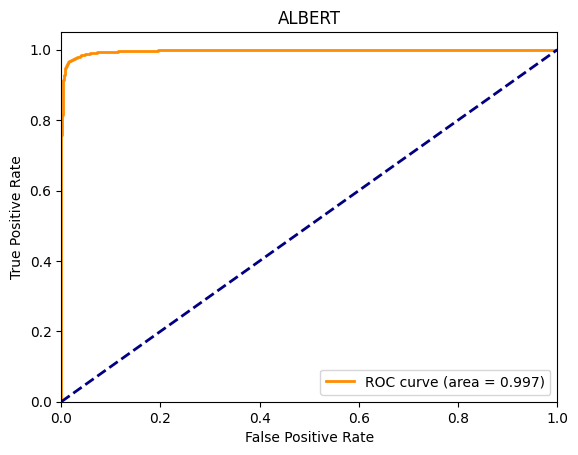

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_predict_prob)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

**Testing: Fake and real news dataset**

In [ ]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 206s 147ms/step - loss: 0.5902 - tp: 22721.0000 - fp: 8810.0000 - tn: 12607.0000 - fn: 760.0000 - accuracy: 0.7869 - precision: 0.7206 - recall: 0.9676 - auc: 0.9421


In [ ]:
print(f'ALBERT accuracy FNDataset: {score[5]}')

ALBERT accuracy FNDataset: 0.7868502140045166


In [ ]:
model.save('/content/drive/MyDrive/Models/FINAL/ALBERT_freezed.h5')